# Exploring approaches to energy production modelling and anomaly detection in solar array data

June 23rd 2019

Gareth Walker

## Breifing
Detect faults in solar array energy production

## Data
Data downloaded from: 
http://dkasolarcentre.com.au/




## Approaches Explored

### Time-series approaches

1) Deviation from the mean

2) Support Vectors

3) K Means Clustering

4) ARIMA

### Physical model based approaches

1) Horizontal Radiation and Humidity as predictors




## Conclusions
#### Note: Could we also compare shift in error between two adjacent arrays? (i.e. different data set from different array)


And then we can combine all of these into a single  model with a re-enforcement: model will need to be able to handle non linier interactions between features: random forrest, boosted models, Neural Nets.


#  Data exploration and preperation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from datetime import datetime  
from datetime import timedelta 
import numpy as np

### Trina, 5.3kW, mono-Si, Fixed, 2009

Array Rating	5.25kW

Panel Rating	175W

Number Of Panels	30

Panel Type	Trina TSM-175DC01

Array Area	38.37 m²

Type Of Tracker	N/A

Inverter Size / Type	6 kW, SMA SMC 6000A

Installation Completed	Thu, 8 Jan 2009

Array Tilt/Azimuth	Tilt = 20, Azi = 0 (Solar North)



In [24]:
au_data = pd.read_csv('92-Site_13-Trina.csv')
# notes on this dta: http://dkasolarcentre.com.au/source/alice-springs/dka-m6-b-phase


In [22]:


def clean_data(df,prexif):
    
    column_names = df.columns   #clean up column names
    clean_names = []
    for name in column_names:
        clean_names.append(name.replace(prefix,''))
    df.columns = clean_names

    data_cols = ['Active Energy Delivered-Received (kWh)',  #define data columns
     'Current Phase Average (A)',
     'Active Power (kW)',
     'Performance Ratio (%)',
     'Wind Speed (m/s)',
     'Weather Temperature Celsius (°C)',
     'Weather Relative Humidity (%)',
     'Global Horizontal Radiation (W/m²)',
     'Diffuse Horizontal Radiation (W/m²)',
     'Wind Direction (Degrees)',
     'Weather Daily Rainfall (mm)']

    df.index=pd.to_datetime(df.Timestamp) #convert index to time series

    df = df[data_cols]  # select data columns

    #Creat consistent time sereis and impute missing timestamps (null for now)

    df = df.fillna(0)
    new_index=pd.date_range('2009-01-08 00:00:00', '2019-06-16 01:40:00', freq='5min')
    df_imputed = pd.DataFrame(index=new_index)
    df_imputed = df.asof(pd.DatetimeIndex(new_index))
    df_imputed = df_imputed.fillna(0)
    
    return df_imputed


In [25]:
prefix = '13 Trina - '
au_imputed = clean_data(au_data,prefix)

### Inspect data

In [26]:
au_imputed.head()

Active Energy Delivered-Received (kWh)  \
2009-01-08 00:00:00                                  1496.0   
2009-01-08 00:05:00                                  1496.0   
2009-01-08 00:10:00                                  1496.0   
2009-01-08 00:15:00                                  1496.0   
2009-01-08 00:20:00                                  1496.0   

                     Current Phase Average (A)  Active Power (kW)  \
2009-01-08 00:00:00                        0.3                0.0   
2009-01-08 00:05:00                        0.3                0.0   
2009-01-08 00:10:00                        0.3                0.0   
2009-01-08 00:15:00                        0.3                0.0   
2009-01-08 00:20:00                        0.3                0.0   

                     Performance Ratio (%)  Wind Speed (m/s)  \
2009-01-08 00:00:00                    0.0          1.578666   
2009-01-08 00:05:00                    0.0          1.879413   
2009-01-08 00:10:00                    0.0          1.765830   
2009-01-08 00:15:00                    0.0          1.952622   
2009-01-08 00:20:00                    0.0          1.824700   

                     Weather Temperature Celsius (°C)  \
2009-01-08 00:00:00                         25.299904   
2009-01-08 00:05:00                         25.346550   
2009-01-08 00:10:00                         25.234707   
2009-01-08 00:15:00                         25.103636   
2009-01-08 00:20:00                         24.974028   

                     Weather Relative Humidity (%)  \
2009-01-08 00:00:00                      61.342018   
2009-01-08 00:05:00                      62.459885   
2009-01-08 00:10:00                      64.383339   
2009-01-08 00:15:00                      65.610954   
2009-01-08 00:20:00                      66.294189   

                     Global Horizontal Radiation (W/m²)  \
2009-01-08 00:00:00                            2.513441   
2009-01-08 00:05:00                            2.892411   
2009-01-08 00:10:00                            3.673305   
2009-01-08 00:15:00                            4.003631   
2009-01-08 00:20:00                            3.969510   

                     Diffuse Horizontal Radiation (W/m²)  \
2009-01-08 00:00:00                             0.279128   
2009-01-08 00:05:00                             0.380444   
2009-01-08 00:10:00                             0.722866   
2009-01-08 00:15:00                             1.005973   
2009-01-08 00:20:00                             1.028586   

                     Wind Direction (Degrees)  Weather Daily Rainfall (mm)  
2009-01-08 00:00:00                204.124634                          0.0  
2009-01-08 00:05:00                209.897430                          0.0  
2009-01-08 00:10:00                212.415588                          0.0  
2009-01-08 00:15:00                209.188934                          0.0  
2009-01-08 00:20:00                204.222534                          0.0

## Define Target Anomalies

The disconnection and re-connection of the solar arrays and weather station equipment while a new site connection was being established prompted the already flattening UPS batteries which power the site’s energy meters to fail and require immediate replacement. Data recording was affected from approximately 2.30pm ACST, Monday 10 July to 4.00pm, Wednesday 12 July.

(736517.0, 736525.0)

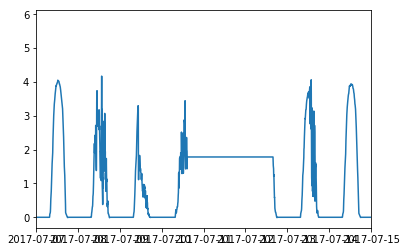

In [27]:
plt.plot(au_imputed['Active Power (kW)'])
plt.xlim('2017-07-07','2017-07-15')

# Time-Series Approaches

These approaches use only the time series data of the independent variable, identifying patterns over time and deviations from it.



## Mean Average approach

Text(0, 0.5, 'Active Power (kW)')

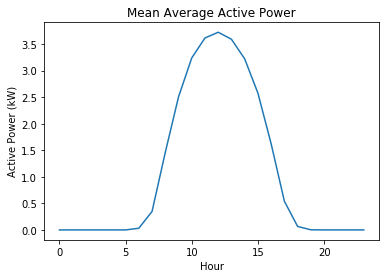

In [28]:
average = au_imputed['Active Power (kW)'].groupby(au_imputed['Active Power (kW)'].index.hour).mean()
plt.plot(average)
plt.title('Mean Average Active Power')
plt.xlabel('Hour')
plt.ylabel('Active Power (kW)')

This looks intuativley correct: energy production is approximatly normally distributed around mid-day
However, how much variance is there in this value? If there is high variance, it may not serve as a good metric 
to judge anomolies against.

In [29]:
import math
stats = au_imputed['Active Power (kW)'].groupby(au_imputed['Active Power (kW)'].index.hour).agg(['mean', 'count', 'std'])

ci99_hi = []
ci99_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci99_hi.append(m + 2.58*s/math.sqrt(c))
    ci99_lo.append(m - 2.58*s/math.sqrt(c))
    
stats['ci99_hi'] = ci99_hi
stats['ci99_lo'] = ci99_lo

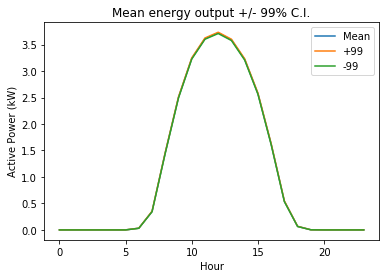

In [30]:
plt.plot(stats['mean'], label = 'Mean')
plt.plot(stats['ci99_hi'], label = '+99')
plt.plot(stats['ci99_lo'], label = '-99')
plt.title('Mean energy output +/- 99% C.I.')
plt.xlabel('Hour')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.show()

Looks like a very tight 99% C.I aroud the curve, which is reassuring, but I'd like to take a closer look

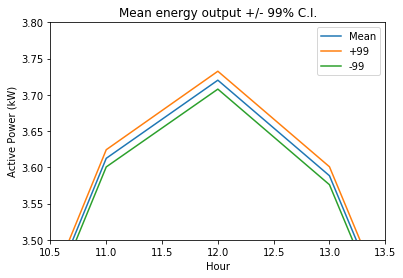

In [31]:
plt.plot(stats['mean'], label = 'Mean')
plt.plot(stats['ci99_hi'], label = '+99')
plt.plot(stats['ci99_lo'], label = '-99')
plt.title('Mean energy output +/- 99% C.I.')
plt.xlabel('Hour')
plt.ylabel('Active Power (kW)')
plt.xlim(10.5,13.5)
plt.ylim(3.5,3.8)
plt.legend()
plt.show()

Lets compare this to a known date for a fault (given in meta data for this array)

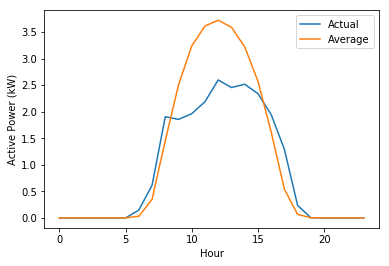

In [36]:
smoothed_daily = au_imputed['2009-01-20':'2009-01-20'].resample('H').mean()['Active Power (kW)'].values
plt.plot(smoothed_daily, label = 'Actual')
plt.plot(average, label = 'Average')
plt.xlabel('Hour')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.show()

In [394]:
from sklearn.metrics import mean_squared_error
meanSquaredError=mean_squared_error(smoothed_daily, average)
print(meanSquaredError)


0.10673480820006043


So we can see that for this fault, the energy output showed a deviation from the mean average resulting in 0.106 mean squared eerror betweent he two

### Evaluate entire time sereies against the mean

In [8]:
from datetime import datetime  
from datetime import timedelta  

date1 = '2009-01-08'
date2 = '2019-06-15'
mydates = pd.date_range(date1, date2).tolist()

errors = pd.DataFrame()

for day in mydates:
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    smoothed_daily = au_data_imputed[day:next_day].resample('H').mean()['Active Power (kW)'].values
    meanSquaredError=mean_squared_error(smoothed_daily, average)
    errors.loc[day,'error'] = meanSquaredError

### ...and then select the top 1% of errors

In [10]:
error = errors.values
anomoly_mask = errors >= np.percentile(error, 99)
anomalies = errors[anomoly_mask.values]

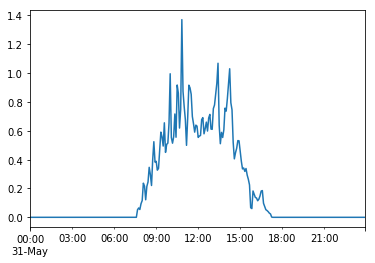

In [547]:
au_data_imputed['2009-05-31':'2009-05-31']['Active Power (kW)'].plot()

In [218]:
len(anomalies)

77

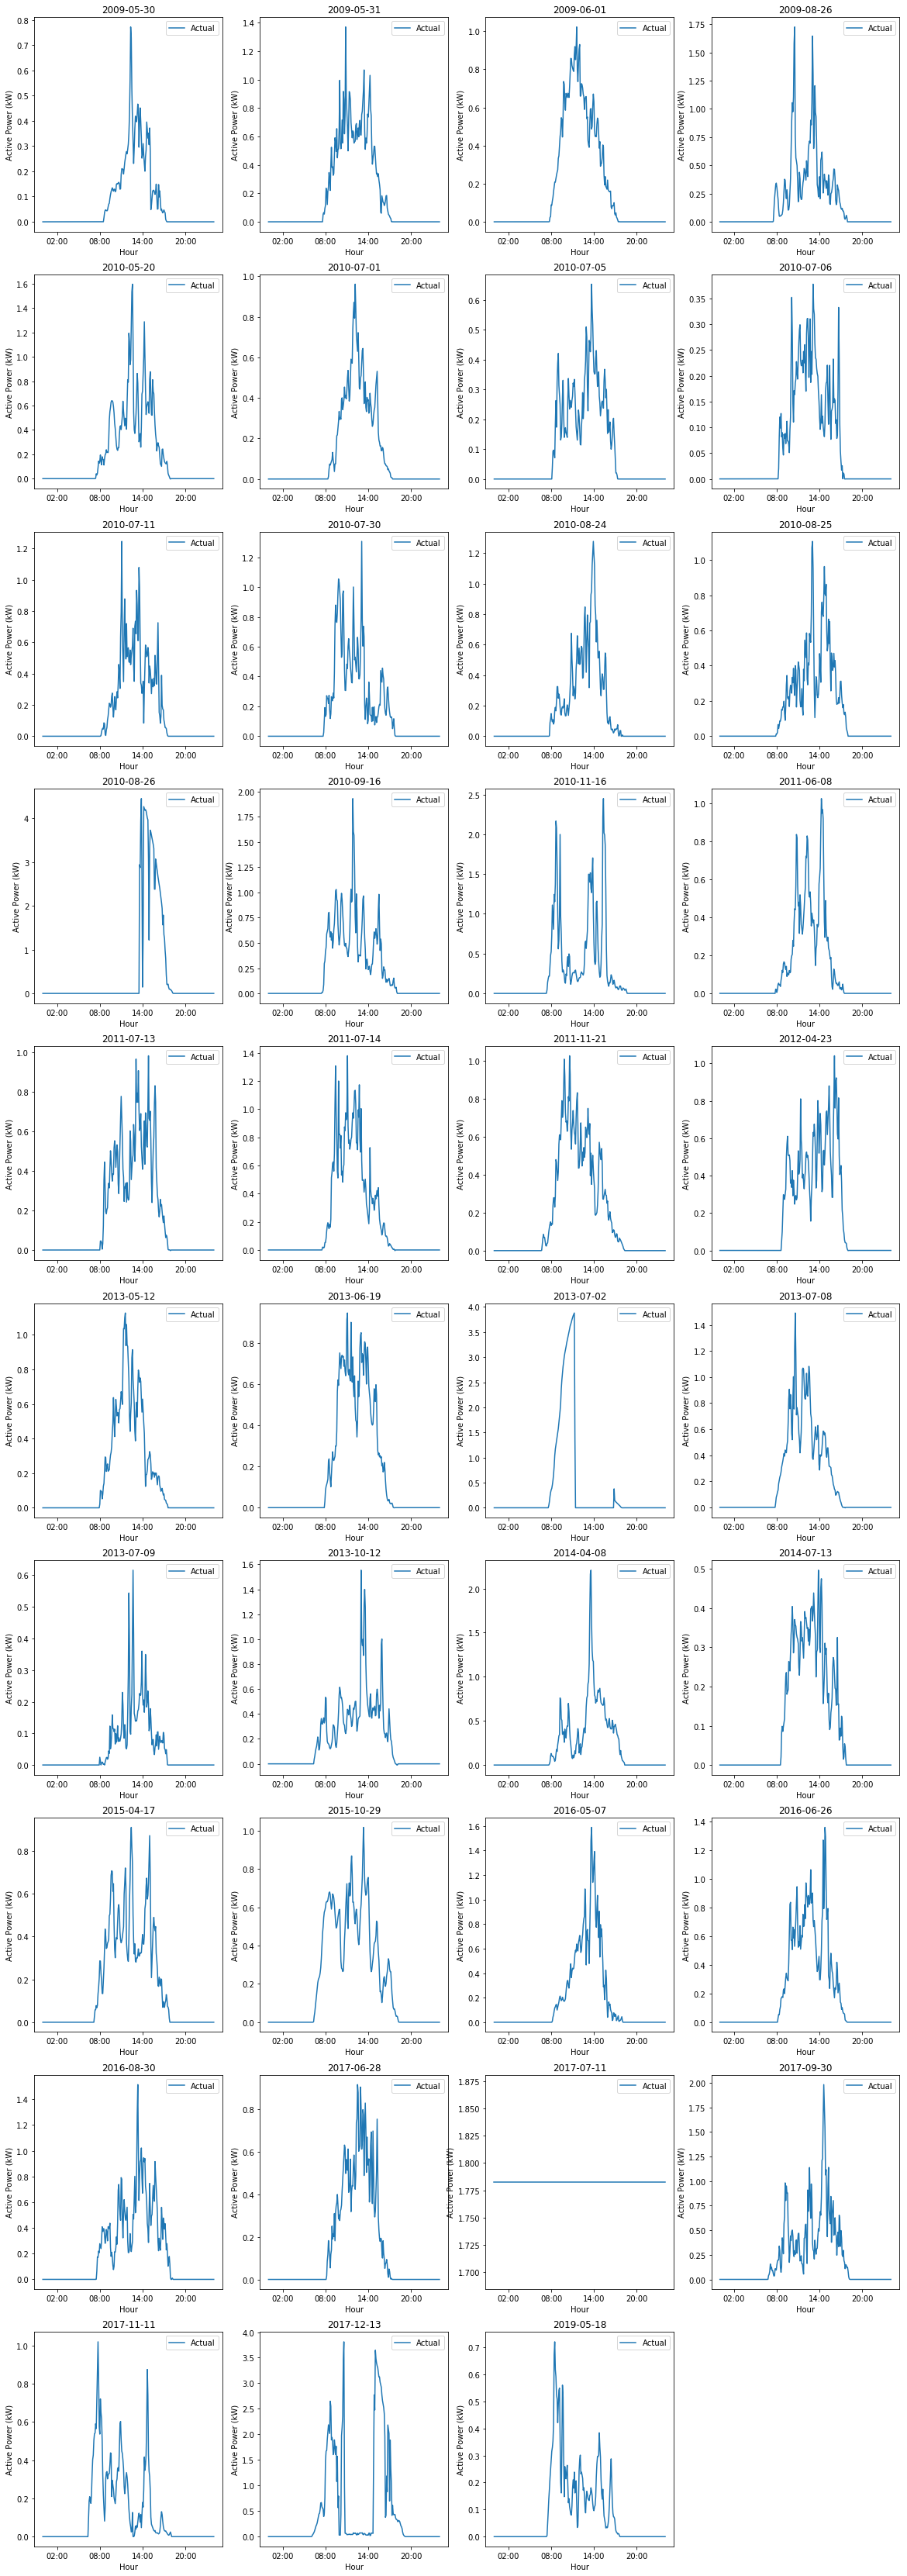

In [16]:
years = mdates.YearLocator
months = mdates.MonthLocator
days = mdates.DayLocator
hours = mdates.HourLocator
hour_fmt = mdates.DateFormatter('%H:%M')

plots = len(anomalies)
plt.figure(figsize=(20,60))

for plot in range(plots):
    
    day = anomalies.index[plot].date()
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    
    ax = plt.subplot((plots/4)+1,4,plot+1)
    ax.xaxis.set_major_locator(hours(interval=6))
    ax.xaxis.set_major_formatter(hour_fmt)
    plt.xlabel('Hour')
    plt.ylabel('Active Power (kW)')
    plt.title(day)
    
    plt.plot(au_data_imputed['Active Power (kW)'][day:next_day],label='Actual')
    #plt.plot(au_data_imputed['y_pred'][day:next_day],label='Predicted')
    plt.legend()

# KMEANs APPROACH

In [630]:
time_series_data = au_data_imputed['Active Power (kW)']['2010-01':'2010-02']

In [631]:

import numpy as np
segment_len = 12
slide_len = 2
segments = []
for start_pos in range(0, len(time_series_data ), slide_len):
    end_pos = start_pos + segment_len
    segment = np.copy(time_series_data [start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

In [632]:
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

In [655]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=7)
clusterer.fit(windowed_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [656]:
#placeholder reconstruction array
reconstruction = np.zeros(len(time_series_data))
slide_len = 2 #segment_len/2
# slide_len = 16 as opposed to a slide_len = 2. Slide_len = 2 was used to create a lot of horizontal translations to provide K-Means with a lot of data. 

for segment_n, segment in enumerate(segments):
    # normalize by multiplying our window function to each segment
    segment *= window
    # sklearn uses the euclidean square distance to predict the centroid
    nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # reconstructed our segments with an overlap equal to the slide_len so the centroids are stitched together perfectly. 
    pos = segment_n * slide_len
    reconstruction[int(pos):int(pos+segment_len)] += nearest_centroid

Maximum reconstruction error was 3.8
98th percentile of reconstruction error was 2.2


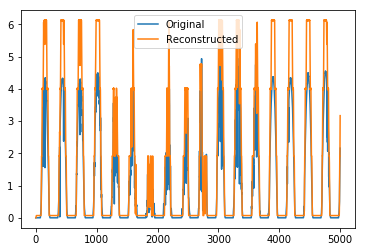

In [658]:
n_plot_samples = 5000

error = reconstruction[0:n_plot_samples] - time_series_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(time_series_data[0:n_plot_samples].values, label="Original")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed")
#plt.plot(error[0:n_plot_samples].values, label="Reconstruction Error")
plt.legend()
plt.show()

## SVM approach

In [147]:

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [917]:
sampled_data = au_data_imputed['Active Power (kW)']['2017'].resample('H').mean()
data = np.asarray(sampled_data).reshape(-1, 1)

In [940]:
def detect_outliers(sampled_data,fraction):
    data = np.asarray(sampled_data).reshape(-1, 1)
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    # train oneclassSVM 
    model = OneClassSVM(nu=fraction, kernel="rbf", gamma=0.01)
    model.fit(data)
    outlier_data = pd.Series(model.predict(data))
    outlier_mask = (outlier_data == -1)
    outlier_mask = outlier_mask.values
    print(sum(outlier_mask))
    return outlier_mask


In [941]:
outliers = detect_outliers(sampled_data,0.0014)

14


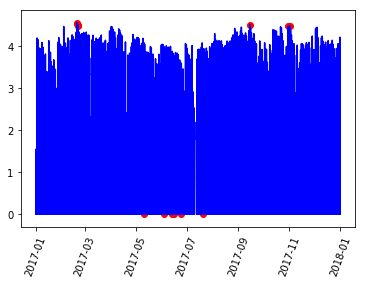

In [943]:



plt.plot(sampled_data, color='blue', label='Normal')
plt.scatter(sampled_data[outliers].index,sampled_data[outliers].values, color='red', label='Anomaly')
#plt.xlim('2017-07-07','2017-07-15')
plt.xticks(rotation=70)
plt.show()


In [922]:
def explore_parameters(step_size, steps):
    
    outliers_fraction=0.001 
    outlier_count = pd.DataFrame()
    data = np.asarray(sampled_data).reshape(-1, 1)
    for step in range(steps):
        outliers_fraction += step_size     #0.00074
        scaler = StandardScaler()
        np_scaled = scaler.fit_transform(data)
        data = pd.DataFrame(np_scaled)
        # train oneclassSVM 
        model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
        model.fit(data)
        outlier_data = pd.Series(model.predict(data))

        outlier_mask = (outlier_data == -1)
        outlier_mask = outlier_mask.values
        outlier_count.loc[step,'Outlier Fraction'] = outliers_fraction
        outlier_count.loc[step,'Outlier Count'] = sum(outlier_mask)
        
    return outlier_count

In [953]:

def anomoly_explorer(anom,window_size):
    start_day = sampled_data[outliers].index[anom] - timedelta(days=window_size)
    end_day = sampled_data[outliers].index[anom] + timedelta(days=window_size)
   
    plt.plot(sampled_data, color='blue', label='Normal')
    plt.scatter(sampled_data[outliers].index,sampled_data[outliers].values, color='red', label='Anomaly')
    plt.xlim(start_day,end_day)
    plt.xticks(rotation=70)
    return


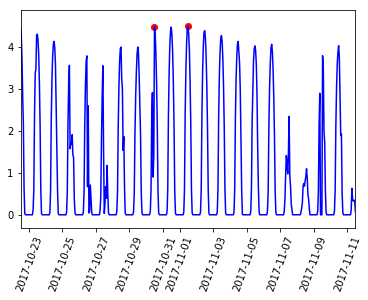

In [958]:
anomoly_explorer(13,10)

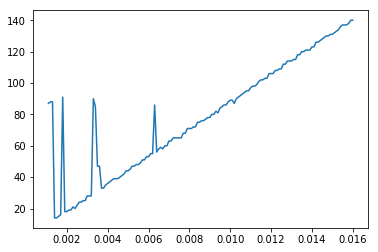

In [934]:
count = explore_parameters(0.0001,150)
plt.plot(count['Outlier Fraction'],count['Outlier Count'])

Note: I'm not happy with the K means clustering or the SVM approach for the same reason: the choice of parameters for the models seems somewhat arbitrary. A cursory exploration of the choice of paramter for the SVM shows it can behave in highly non-linier fashion. I'm also aware of the following research which argues that K-means applied to time series data does not yeild replicable results, in fact they are arbitrary: https://www.cc.gatech.edu/people/home/isbell/classes/reading/papers/Keogh_ICDM_expanded.pdf

## Prediciton based detection

In [968]:
au_data_imputed.head()

Active Energy Delivered-Received (kWh)  \
2009-01-08 00:00:00                                  1496.0   
2009-01-08 00:05:00                                  1496.0   
2009-01-08 00:10:00                                  1496.0   
2009-01-08 00:15:00                                  1496.0   
2009-01-08 00:20:00                                  1496.0   

                     Current Phase Average (A)  Active Power (kW)  \
2009-01-08 00:00:00                        0.3                0.0   
2009-01-08 00:05:00                        0.3                0.0   
2009-01-08 00:10:00                        0.3                0.0   
2009-01-08 00:15:00                        0.3                0.0   
2009-01-08 00:20:00                        0.3                0.0   

                     Performance Ratio (%)  Wind Speed (m/s)  \
2009-01-08 00:00:00                    0.0          1.578666   
2009-01-08 00:05:00                    0.0          1.879413   
2009-01-08 00:10:00                    0.0          1.765830   
2009-01-08 00:15:00                    0.0          1.952622   
2009-01-08 00:20:00                    0.0          1.824700   

                     Weather Temperature Celsius (°C)  \
2009-01-08 00:00:00                         25.299904   
2009-01-08 00:05:00                         25.346550   
2009-01-08 00:10:00                         25.234707   
2009-01-08 00:15:00                         25.103636   
2009-01-08 00:20:00                         24.974028   

                     Weather Relative Humidity (%)  \
2009-01-08 00:00:00                      61.342018   
2009-01-08 00:05:00                      62.459885   
2009-01-08 00:10:00                      64.383339   
2009-01-08 00:15:00                      65.610954   
2009-01-08 00:20:00                      66.294189   

                     Global Horizontal Radiation (W/m²)  \
2009-01-08 00:00:00                            2.513441   
2009-01-08 00:05:00                            2.892411   
2009-01-08 00:10:00                            3.673305   
2009-01-08 00:15:00                            4.003631   
2009-01-08 00:20:00                            3.969510   

                     Diffuse Horizontal Radiation (W/m²)  \
2009-01-08 00:00:00                             0.279128   
2009-01-08 00:05:00                             0.380444   
2009-01-08 00:10:00                             0.722866   
2009-01-08 00:15:00                             1.005973   
2009-01-08 00:20:00                             1.028586   

                     Wind Direction (Degrees)  Weather Daily Rainfall (mm)  
2009-01-08 00:00:00                204.124634                          0.0  
2009-01-08 00:05:00                209.897430                          0.0  
2009-01-08 00:10:00                212.415588                          0.0  
2009-01-08 00:15:00                209.188934                          0.0  
2009-01-08 00:20:00                204.222534                          0.0

In [18]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

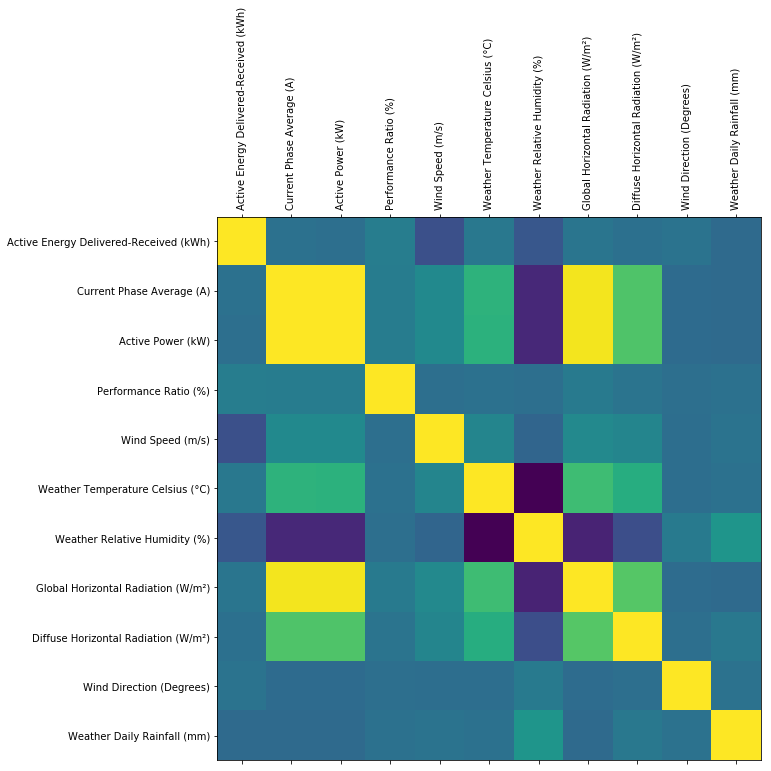

In [19]:
plot_corr(au_data_imputed,size=10)

In [978]:
au_data_imputed.columns

Index(['Active Energy Delivered-Received (kWh)', 'Current Phase Average (A)',
       'Active Power (kW)', 'Performance Ratio (%)', 'Wind Speed (m/s)',
       'Weather Temperature Celsius (°C)', 'Weather Relative Humidity (%)',
       'Global Horizontal Radiation (W/m²)',
       'Diffuse Horizontal Radiation (W/m²)', 'Wind Direction (Degrees)',
       'Weather Daily Rainfall (mm)'],
      dtype='object')

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
#model = LinearRegression(normalize=True)
model = RandomForestRegressor(n_estimators=100)

predictors = ['Weather Relative Humidity (%)', 'Global Horizontal Radiation (W/m²)']
y = au_data_imputed['Active Power (kW)']
X = au_data_imputed[predictors]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [73]:
model.fit(X_train,y_train)
from sklearn.metrics import r2_score

y_pred =model.predict(X_test)
r2_score(y_test, y_pred) 

0.9629153587456568

# Fit to entire data and visualise

In [74]:
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [75]:
au_data_imputed['y_pred'] =model.predict(X)

(736517.0, 736525.0)

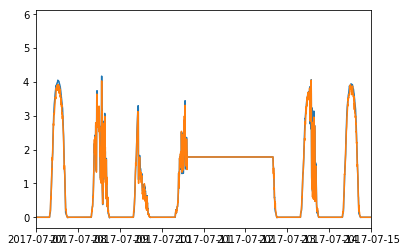

In [76]:
plt.plot(y)
plt.plot(au_data_imputed['y_pred'])
plt.xlim('2017-07-07','2017-07-15')

In [90]:
 


date1 = '2009-01-08'
date2 = '2019-06-15'
mydates = pd.date_range(date1, date2).tolist()

predictive_error = pd.DataFrame()

for day in mydates:
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    MSE =mean_squared_error(au_data_imputed['y_pred'][day:next_day], au_data_imputed['Active Power (kW)'][day:next_day])
    predictive_error.loc[day,'error'] = MSE


In [91]:

anomoly_mask = predictive_error.values >= np.percentile(predictive_error.values, 99.0)
anomalies = predictive_error[anomoly_mask]

In [198]:
# Example of sensors being out, rather than generation

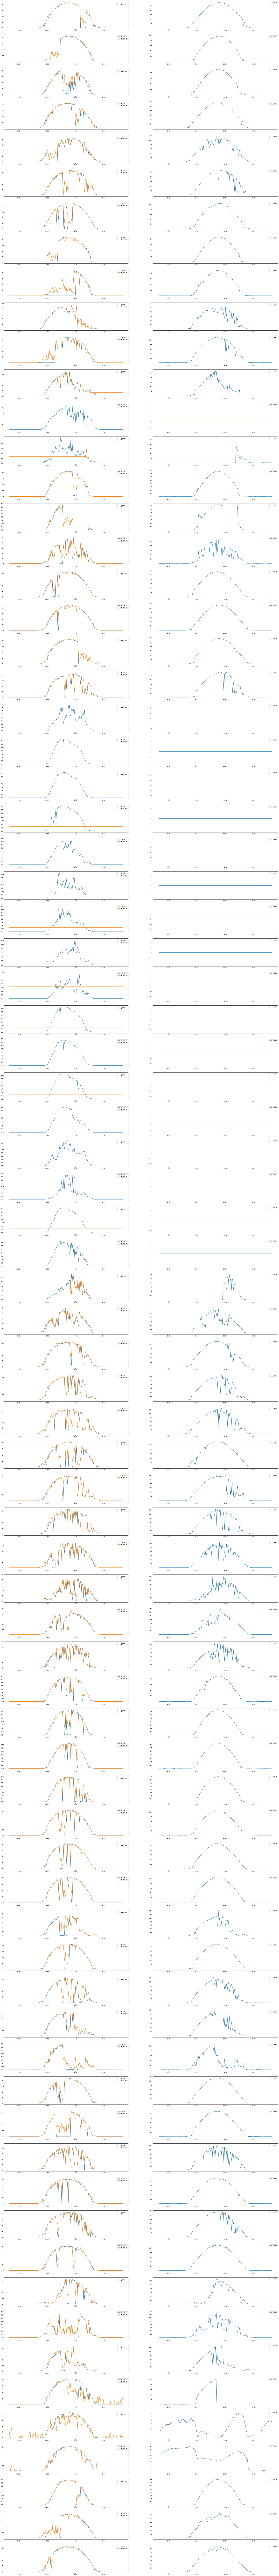

In [199]:

years = mdates.YearLocator
months = mdates.MonthLocator
days = mdates.DayLocator
hours = mdates.HourLocator
hour_fmt = mdates.DateFormatter('%H:%M')

plots = len(anomalies)
plt.figure(figsize=(20,80))

for plot in range(plots):
    
    day = anomalies.index[plot].date()
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    
    ax = plt.subplot(plots,2,plot+plot+1)
    ax.xaxis.set_major_locator(hours(interval=6))
    ax.xaxis.set_major_formatter(hour_fmt)
    
    plt.plot(au_data_imputed['Active Power (kW)'][day:next_day],label='Actual')
    plt.plot(au_data_imputed['y_pred'][day:next_day],label='Predicted')
    plt.legend()

    ax = plt.subplot(plots,2,plot+plot+2)
    ax.xaxis.set_major_locator(hours(interval=6))
    ax.xaxis.set_major_formatter(hour_fmt)
    
    plt.plot(au_data_imputed['Global Horizontal Radiation (W/m²)'][day:next_day],label='W/m²')
    plt.legend()



# ARIMA Approach

In [94]:
from statsmodels.tsa.arima_model import ARIMA

In [1010]:
au_data_imputed['y_pred'] = y_pred

In [1101]:
#au_data_imputed['y_pred']

In [95]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y.values, freq=288)

au_data_imputed['trend'] = result.trend
au_data_imputed['trend'] = au_data_imputed['trend'].fillna(0)

au_data_imputed['seasonal'] = result.seasonal
au_data_imputed['seasonal'] = au_data_imputed['seasonal'].fillna(0)


au_data_imputed['residual'] = result.resid
au_data_imputed['residual'] = au_data_imputed['residual'].fillna(0)



(736517.0, 736530.0)

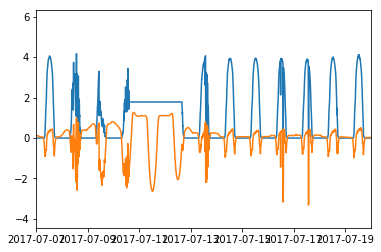

In [1072]:
#plt.plot(au_data_imputed['trend'])
plt.plot(y)
#plt.plot(au_data_imputed['seasonal'])
plt.plot(au_data_imputed['residual'])
plt.xlim('2017-07-07','2017-07-20')

In [96]:
from scipy.integrate import simps  
# In this instance I have taken the integral of the absolute to be effectivly the same as root mean error
date1 = '2009-01-08'
date2 = '2019-06-15'
mydates = pd.date_range(date1, date2).tolist()

arima_error = pd.DataFrame()

for day in mydates:
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    integral_error =simps(au_data_imputed['residual'][day:next_day].abs())
    arima_error.loc[day,'error'] = integral_error



In [157]:


anomoly_mask = arima_error.values >= np.percentile(arima_error.values, 99.)

errors[anomoly_mask].head()

error
2009-05-30  0.000364
2009-05-31  0.000295
2009-06-01  0.000255
2009-08-26  0.000788
2010-05-20  0.000341

(735056.0, 735059.0)

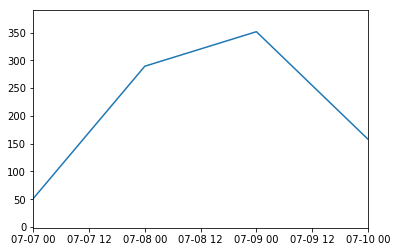

In [1098]:
plt.plot(errors['error'])
#plt.plot(y)
plt.xlim('2013-07-07','2013-07-10')

(735056.0, 735064.0)

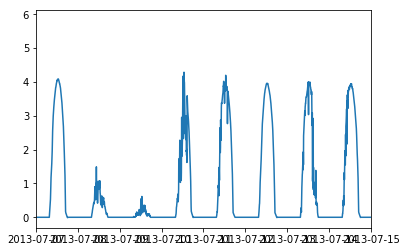

In [1100]:
plt.plot(y)
plt.xlim('2013-07-07','2013-07-15')

# Peer approach

In [48]:
prefix = '14 Kyocera - '

In [42]:
au_data_2 = pd.read_csv('90-Site_14-Kyocera.csv')

In [53]:
au_imputed_2 = clean_data(au_data,prefix)

In [51]:
au_imputed_2.head()

Active Energy Delivered-Received (kWh)  \
2009-01-08 00:00:00                                  3028.0   
2009-01-08 00:05:00                                  3028.0   
2009-01-08 00:10:00                                  3028.0   
2009-01-08 00:15:00                                  3028.0   
2009-01-08 00:20:00                                  3028.0   

                     Current Phase Average (A)  Active Power (kW)  \
2009-01-08 00:00:00                        0.4                0.0   
2009-01-08 00:05:00                        0.4                0.0   
2009-01-08 00:10:00                        0.4                0.0   
2009-01-08 00:15:00                        0.4                0.0   
2009-01-08 00:20:00                        0.4                0.0   

                     Performance Ratio (%)  Wind Speed (m/s)  \
2009-01-08 00:00:00                    0.0          1.578666   
2009-01-08 00:05:00                    0.0          1.879413   
2009-01-08 00:10:00                    0.0          1.765830   
2009-01-08 00:15:00                    0.0          1.952622   
2009-01-08 00:20:00                    0.0          1.824700   

                     Weather Temperature Celsius (°C)  \
2009-01-08 00:00:00                         25.299904   
2009-01-08 00:05:00                         25.346550   
2009-01-08 00:10:00                         25.234707   
2009-01-08 00:15:00                         25.103636   
2009-01-08 00:20:00                         24.974028   

                     Weather Relative Humidity (%)  \
2009-01-08 00:00:00                      61.342018   
2009-01-08 00:05:00                      62.459885   
2009-01-08 00:10:00                      64.383339   
2009-01-08 00:15:00                      65.610954   
2009-01-08 00:20:00                      66.294189   

                     Global Horizontal Radiation (W/m²)  \
2009-01-08 00:00:00                            2.513441   
2009-01-08 00:05:00                            2.892411   
2009-01-08 00:10:00                            3.673305   
2009-01-08 00:15:00                            4.003631   
2009-01-08 00:20:00                            3.969510   

                     Diffuse Horizontal Radiation (W/m²)  \
2009-01-08 00:00:00                             0.279128   
2009-01-08 00:05:00                             0.380444   
2009-01-08 00:10:00                             0.722866   
2009-01-08 00:15:00                             1.005973   
2009-01-08 00:20:00                             1.028586   

                     Wind Direction (Degrees)  Weather Daily Rainfall (mm)  
2009-01-08 00:00:00                204.124634                          0.0  
2009-01-08 00:05:00                209.897430                          0.0  
2009-01-08 00:10:00                212.415588                          0.0  
2009-01-08 00:15:00                209.188934                          0.0  
2009-01-08 00:20:00                204.222534                          0.0

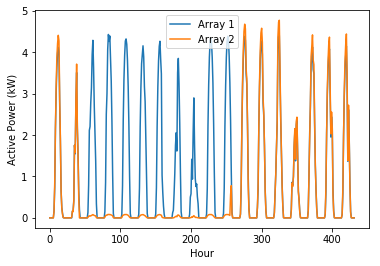

In [62]:
smoothed_daily_1 = au_imputed['2013-12-03':'2013-12-20'].resample('H').mean()['Active Power (kW)'].values
smoothed_daily_2 = au_imputed_2['2013-12-03':'2013-12-20'].resample('H').mean()['Active Power (kW)'].values
plt.plot(smoothed_daily_1, label = 'Array 1')
plt.plot(smoothed_daily_2, label = 'Array 2')
plt.xlabel('Hour')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.show()

In [ ]:
'2017-07-07','2017-07-15'

In [69]:
 


date1 = '2009-01-08'
date2 = '2019-06-15'
mydates = pd.date_range(date1, date2).tolist()

peer_error = pd.DataFrame()

for day in mydates:
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    MSE =mean_squared_error(au_data_imputed_2['Active Power (kW)'][day:next_day], au_data_imputed['Active Power (kW)'][day:next_day])
    peer_error.loc[day,'error'] = MSE


In [66]:
peer_error = peer_error.values
anomoly_mask = peer_error >= np.percentile(peer_error, 99.0)
anomalies = peer_error[anomoly_mask.values]

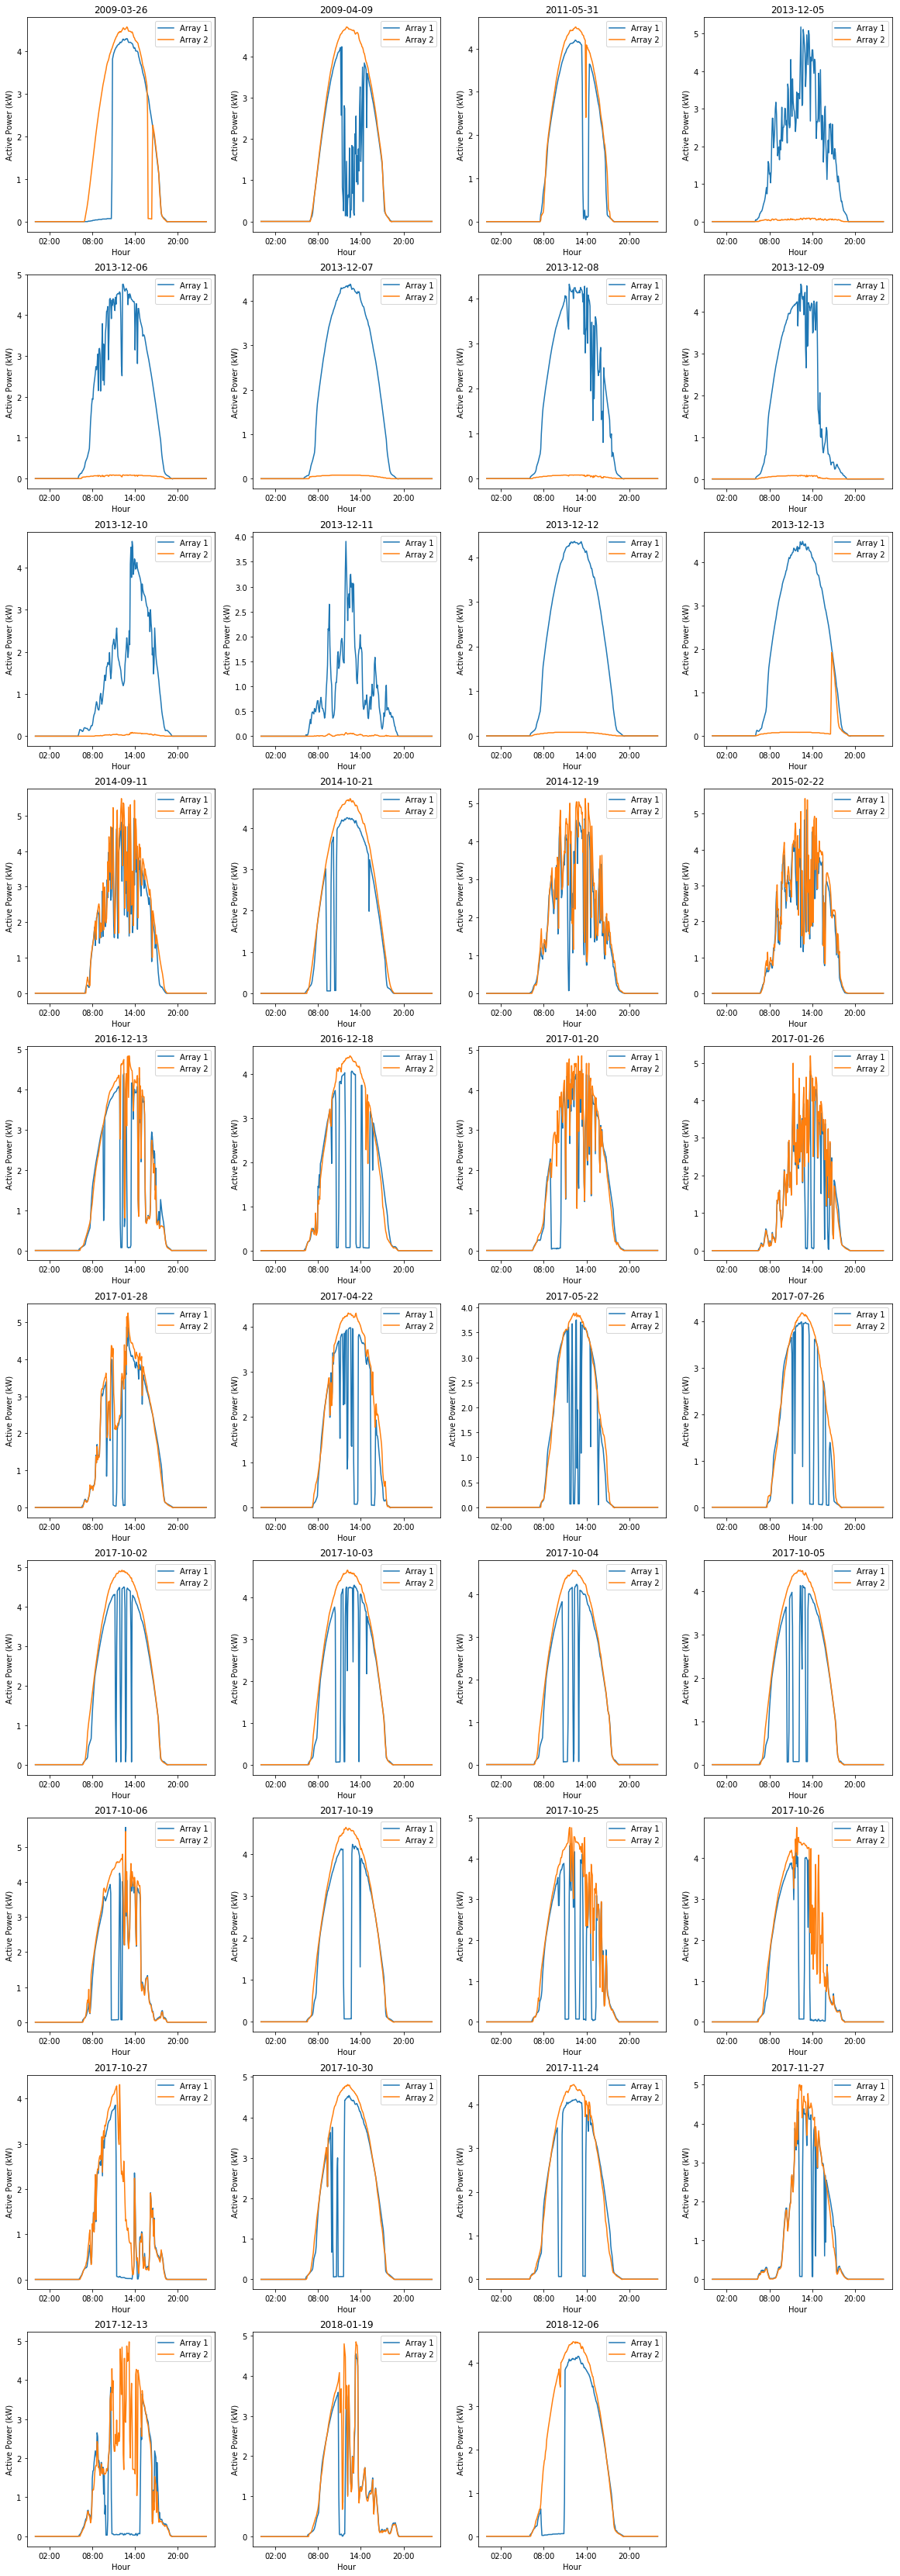

In [68]:
years = mdates.YearLocator
months = mdates.MonthLocator
days = mdates.DayLocator
hours = mdates.HourLocator
hour_fmt = mdates.DateFormatter('%H:%M')

plots = len(anomalies)
plt.figure(figsize=(20,60))

for plot in range(plots):
    
    day = anomalies.index[plot].date()
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    
    ax = plt.subplot((plots/4)+1,4,plot+1)
    ax.xaxis.set_major_locator(hours(interval=6))
    ax.xaxis.set_major_formatter(hour_fmt)
    plt.xlabel('Hour')
    plt.ylabel('Active Power (kW)')
    plt.title(day)
    
    plt.plot(au_data_imputed['Active Power (kW)'][day:next_day],label='Array 1')
    plt.plot(au_data_imputed_2['Active Power (kW)'][day:next_day],label='Array 2')
    #plt.plot(au_data_imputed['y_pred'][day:next_day],label='Predicted')
    plt.legend()

# error comparisons and combinations

In [147]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

predictive_error_scaled = pd.Series(data = min_max_scaler.fit_transform(predictive_error).flatten(),index = predictive_error.index)
arima_error_scaled = pd.Series(data =min_max_scaler.fit_transform(arima_error).flatten(), index = arima_error.index)
peer_error_scaled = pd.Series(min_max_scaler.fit_transform(peer_error).flatten(), index =peer_error.index)




In [141]:
predictive_error_scaled.flatten()

array([0.00559493, 0.00355322, 0.00295424, ..., 0.00144567, 0.00109377,
       0.00160957])

(736313.0, 736323.0)

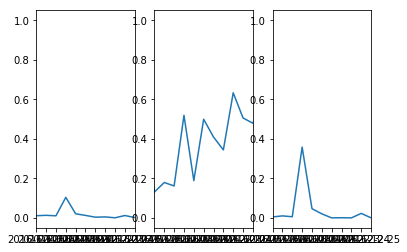

In [152]:
start = '2016-12-15'
end = '2016-12-25'

#plt.subplot(1,2,1)
#plt.plot(peer_error)
plt.subplot(1,3,1)
plt.plot(predictive_error_scaled)
plt.xlim(start,end)
plt.subplot(1,3,2)
plt.plot(arima_error_scaled)
plt.xlim(start,end)
plt.subplot(1,3,3)
plt.plot(peer_error_scaled)
plt.xlim(start,end)


In [155]:
combined_peer_predictive = predictive_error_scaled + peer_error_scaled


anomoly_mask = combined_peer_predictive.values >= np.percentile(combined_peer_predictive.values, 99.0)
anomalies = combined_peer_predictive[anomoly_mask]

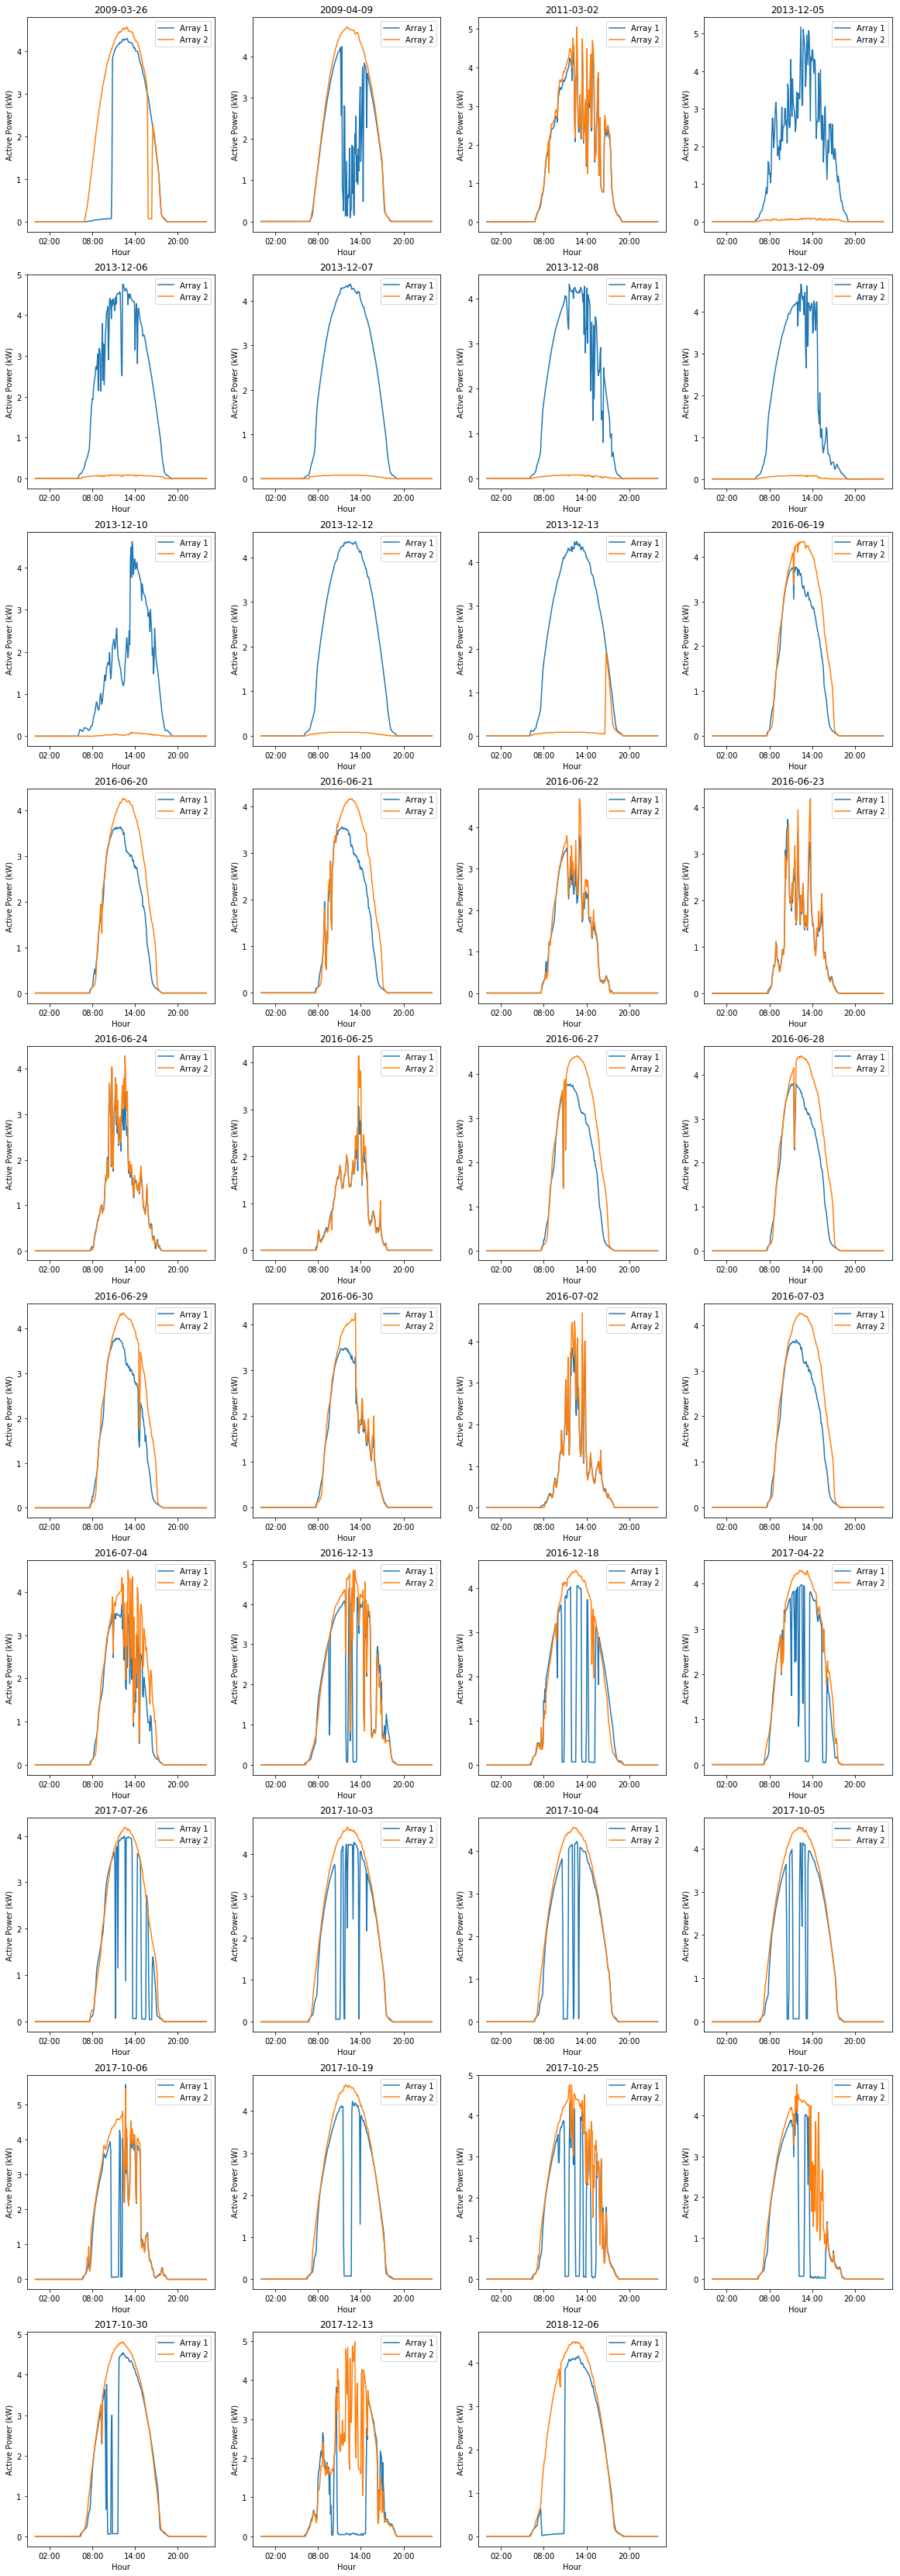

In [156]:
years = mdates.YearLocator
months = mdates.MonthLocator
days = mdates.DayLocator
hours = mdates.HourLocator
hour_fmt = mdates.DateFormatter('%H:%M')

plots = len(anomalies)
plt.figure(figsize=(20,60))

for plot in range(plots):
    
    day = anomalies.index[plot].date()
    next_day = day + timedelta(days=1)  - timedelta(minutes=10)
    
    ax = plt.subplot((plots/4)+1,4,plot+1)
    ax.xaxis.set_major_locator(hours(interval=6))
    ax.xaxis.set_major_formatter(hour_fmt)
    plt.xlabel('Hour')
    plt.ylabel('Active Power (kW)')
    plt.title(day)
    
    plt.plot(au_data_imputed['Active Power (kW)'][day:next_day],label='Array 1')
    plt.plot(au_data_imputed_2['Active Power (kW)'][day:next_day],label='Array 2')
    #plt.plot(au_data_imputed['y_pred'][day:next_day],label='Predicted')
    plt.legend()